In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df = pd.read_csv('jalandhar10.csv')

In [3]:
df.head()

,time,soilmoisture7to28cm,temperature2m,relativehumidity2m,precipitation
0,2013-12-15T00:00,0.174,9.5,92,0.0
1,2013-12-15T01:00,0.174,9.3,93,0.0
2,2013-12-15T02:00,0.174,9.1,93,0.0
3,2013-12-15T03:00,0.174,10.7,90,0.0
4,2013-12-15T04:00,0.174,14.7,73,0.0


In [4]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M')

In [5]:
df.count()

time                   87672
soilmoisture7to28cm    87672
temperature2m          87672
relativehumidity2m     87672
precipitation          87672
dtype: int64

In [8]:
df1 = df.copy()

In [9]:
df1.set_index('time', inplace=True)

In [10]:
df1.head()

,soilmoisture7to28cm,temperature2m,relativehumidity2m,precipitation
time,,,,
2013-12-15 00:00:00,0.174,9.5,92,0.0
2013-12-15 01:00:00,0.174,9.3,93,0.0
2013-12-15 02:00:00,0.174,9.1,93,0.0
2013-12-15 03:00:00,0.174,10.7,90,0.0
2013-12-15 04:00:00,0.174,14.7,73,0.0


In [11]:
features = df1.to_numpy()
target = df1.to_numpy()[:, 0]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [15]:
win_length = 48
batch_size = 8760
num_features = 4
train_gen = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [16]:
m = Sequential()
m.add(LSTM(128,activation = 'sigmoid', input_shape=(win_length, num_features), return_sequences=True))
#m.add(LeakyReLU(alpha=0.5))
m.add(LSTM(64,activation = 'sigmoid', return_sequences=True))
#m.add(LeakyReLU(alpha=0.5))
#m.add(Dropout(0.2))
m.add(LSTM(32, return_sequences=True))
#m.add(Dropout(0.2))
m.add(LSTM(32, return_sequences=False))
m.add(Dense(1))

In [17]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 48, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 48, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 138273 (540.13 KB)
Trainable params: 138273 (540.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
from tensorflow.keras.optimizers.legacy import Adam

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

m.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

history = m.fit(train_gen, epochs=15, validation_data=test_gen, shuffle=False, callbacks=[early_stopping])

Epoch 1/15


9/9 [==============================] - 154s 14s/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 2/15
9/9 [==============================] - 119s 13s/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 3/15
9/9 [==============================] - 114s 13s/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 4/15
9/9 [==============================] - 114s 13s/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 5/15
9/9 [==============================] - 144s 16s/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/15
9/9 [==============================] - 109s 12s/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 7/15
9/9 [==============================] - 115s 13s/step - loss: 0.0045 - accuracy: 0.0000e+00 - val_lo

In [20]:
m.evaluate_generator(test_gen, verbose=0)

C:\Users\amang\AppData\Local\Temp\ipykernel_5088\1688752275.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  m.evaluate_generator(test_gen, verbose=0)


[0.002420394914224744, 0.0]

In [21]:
predictions = m.predict(test_gen)

2/2 [==============================] - 14s 5s/step


In [22]:
len(predictions)

17487

In [23]:
df1.head()

,soilmoisture7to28cm,temperature2m,relativehumidity2m,precipitation
time,,,,
2013-12-15 00:00:00,0.174,9.5,92,0.0
2013-12-15 01:00:00,0.174,9.3,93,0.0
2013-12-15 02:00:00,0.174,9.1,93,0.0
2013-12-15 03:00:00,0.174,10.7,90,0.0
2013-12-15 04:00:00,0.174,14.7,73,0.0


In [24]:
df2 = df1[['soilmoisture7to28cm']][-len(predictions):].copy()

In [25]:
df2['pred'] = predictions

<Axes: xlabel='time'>

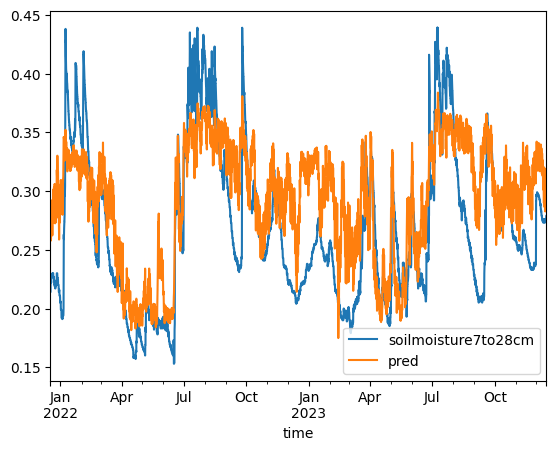

In [26]:
df2.plot(y=["soilmoisture7to28cm", "pred"])